In [1]:
import datetime
from datetime import date
from datetime import datetime
import requests
import pprint
from bs4 import BeautifulSoup
import pandas as pd
import re
import pickle
from urllib.request import urlopen
import glob
# import altair as alt
import time
import itertools
import numpy as np
import operator
from datetime import timedelta
from ipywidgets import interact, IntSlider
from IPython.display import display
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler

# pd.options.display.max_columns = 5000
# pd.options.display.max_rows = 5000

injured_pred = 'injured_in_26_week'

simple_features = ['Height', 'Weight', 'age','cum_injury_total', 'weeks_since_injury', 'Min_cum']

extended_features = ['Height', 'Weight', 'defender', 'attacker', 'midfielder', 'goalkeeper', 'right_foot', 'age', 'cum_injury_total', 'weeks_since_injury', 'Min_cum', 'Gls_cum', 'Ast_cum', 'PK_cum', 'PKatt_cum',
 'Sh_cum', 'SoT_cum', 'CrdY_cum', 'CrdR_cum', 'Touches_cum', 'Press_cum', 'Tkl_cum', 'Int_cum', 'Blocks_cum', 'xG_cum', 'npxG_cum', 'xA_cum', 'SCA_cum', 'GCA_cum', 'Cmp_cum',
 'Att_cum', 'Prog_cum', 'Carries_cum', 'Prog.1_cum', 'Succ_cum', 'Att.1_cum', 'Fls_cum', 'Fld_cum', 'Off_cum', 'Crs_cum', 'TklW_cum', 'OG_cum', 'PKwon_cum','PKcon_cum']

In [2]:
# Load Dataset

# Renzo's Path
# dataset = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1KUGn_35OjAoOP2puz6yG-2g_8LBxvDG_/SIADS 697 - Capstone/Dataframes/complete_final_df_5.csv')

# Sravan's Path
dataset = pd.read_csv('/Users/srav88/My Drive/SIADS 697 - Capstone/Dataframes/dataset_for_model_final.csv')

In [3]:
dataset.loc[(dataset['injury_count'].shift(1) == 1) & (dataset['injury_count'] == 1), 'drop'] = 1
dataset.loc[(dataset['injury_count'].shift(1) == 0) & (dataset['injury_count'] == 1), 'drop'] = 0
dataset.loc[(dataset['injury_count'].shift(1) == 1) & (dataset['injury_count'] == 0), 'drop'] = 0
dataset.loc[(dataset['injury_count'].shift(1) == 0) & (dataset['injury_count'] == 0), 'drop'] = 0
dataset.loc[(dataset['injury_count'] == 1) & (dataset['cum_week'] == 0), 'drop'] = 1

In [4]:
# dataset[dataset['FBRefID']=='dea698d9'].to_csv('/Users/srav88/My Drive/SIADS 697 - Capstone/Dataframes/ronaldo.csv', index=False)
dataset = dataset[dataset['drop'] == 0]
dataset = dataset[dataset['goalkeeper'] == 0]

In [5]:
dataset["last_week"] = dataset.groupby("FBRefID")["cum_week"].transform("last")
dataset["train_split"] = round(dataset["last_week"]*0.75)

In [6]:
# Get Train Test Split
df_train = dataset[dataset['cum_week'] <= dataset["train_split"]].dropna()
df_test = dataset[dataset['cum_week'] > dataset["train_split"]].dropna()

In [7]:
X_train = df_train[extended_features].to_numpy()
y_train = df_train[injured_pred]

X_test = df_test[extended_features].to_numpy()
y_test = df_test[injured_pred]

In [9]:
# nan_values = y_test.isna()
# nan_columns = nan_values.any()

# columns_with_nan = y_test.columns[nan_columns].tolist()
# print(columns_with_nan)

<AxesSubplot:xlabel='injured_in_26_week', ylabel='count'>

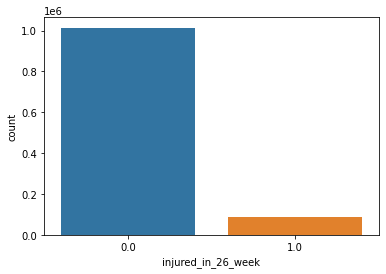

In [10]:
sns.countplot(x=injured_pred,data=df_train)

<AxesSubplot:xlabel='injured_in_26_week', ylabel='count'>

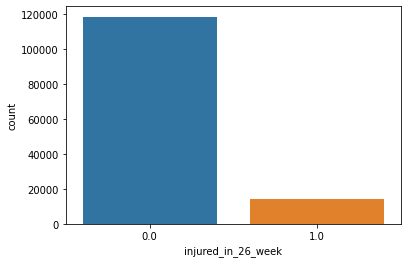

In [11]:
sns.countplot(x=injured_pred,data=df_test)

In [12]:
model_compare = pd.DataFrame(columns=['model', 'precision', 'recall', 'f1-score', 'support'])

# Dummy Classifier

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
scoring = ["accuracy", "balanced_accuracy"]
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [14]:
# index = []
# scores = {"Accuracy": [], "Balanced accuracy": []}

In [15]:
# index += ["Dummy classifier"]
# cv_result = cross_validate(dummy_clf, X_train, y_train, scoring=scoring)
# scores["Accuracy"].append(cv_result["test_accuracy"].mean())
# scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

# df_scores = pd.DataFrame(scores, index=index)
# df_scores

In [16]:
y_pred_dummy = dummy_clf.predict(X_test)

In [17]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_dummy)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_dummy)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_dummy)}')
print(f'Recall score: {recall_score(y_test,y_pred_dummy)}')

Accuracy Score: 0.8916636506213054
Confusion Matrix: 
[[118256      0]
 [ 14368      0]]
Area Under Curve: 0.5
Recall score: 0.0


In [18]:
from sklearn import metrics

def get_classification_report(y_test, y_pred, classifier):
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    df_classification_report = df_classification_report.reset_index()
    df_classification_report = df_classification_report[df_classification_report['index']=='1.0']
    df_classification_report['model'] = classifier    
    return df_classification_report[['model', 'precision', 'recall', 'f1-score', 'support']].reset_index(drop=True)

df = get_classification_report(y_test, y_pred_dummy, 'Dummy Classifier')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [19]:
model_compare = model_compare.append(df)
model_compare.head()

,model,precision,recall,f1-score,support
0,Dummy Classifier,0.0,0.0,0.0,14368.0


# Logistic Regression (Non-Weighted)

In [20]:
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [21]:
# index += ["Logistic regression"]
# cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
# scores["Accuracy"].append(cv_result["test_accuracy"].mean())
# scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

# df_scores = pd.DataFrame(scores, index=index)
# df_scores

In [22]:
y_pred_lr = lr_clf.predict(X_test)

In [24]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_lr)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_lr)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_lr)}')
print(f'Recall score: {recall_score(y_test,y_pred_lr)}')

Accuracy Score: 0.886347870671975
Confusion Matrix: 
[[117277    979]
 [ 14094    274]]
Area Under Curve: 0.5053957530964495
Recall score: 0.019070155902004456


In [25]:
df = get_classification_report(y_test, y_pred_lr, 'Logistic Regression')
model_compare = model_compare.append(df).reset_index(drop=True)
model_compare.head()

,model,precision,recall,f1-score,support
0,Dummy Classifier,0.000000,0.00000,0.000000,14368.0
1,Logistic Regression,0.218675,0.01907,0.035081,14368.0


# Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, n_jobs=2)

# index += ["Random forest"]
# cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring)
# scores["Accuracy"].append(cv_result["test_accuracy"].mean())
# scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

# df_scores = pd.DataFrame(scores, index=index)
# df_scores

In [27]:
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

In [28]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_rf)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_rf)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_rf)}')
print(f'Recall score: {recall_score(y_test,y_pred_rf)}')

Accuracy Score: 0.8887833273012427
Confusion Matrix: 
[[117210   1046]
 [ 13704    664]]
Area Under Curve: 0.5186842956536256
Recall score: 0.04621380846325167


In [29]:
df = get_classification_report(y_test, y_pred_rf, 'Random Forest')
model_compare = model_compare.append(df).reset_index(drop=True)
model_compare.head()

,model,precision,recall,f1-score,support
0,Dummy Classifier,0.000000,0.000000,0.000000,14368.0
1,Logistic Regression,0.218675,0.019070,0.035081,14368.0
2,Random Forest,0.388304,0.046214,0.082597,14368.0


# Balanced Logistic Regression

In [30]:
lr_clf_bal = LogisticRegression(max_iter=1000)
lr_clf_bal.set_params(class_weight="balanced")
lr_clf_bal.fit(X_train, y_train)
y_pred_lr_bal = lr_clf_bal.predict(X_test)

# index += ["Logistic regression with balanced class weights"]
# cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
# scores["Accuracy"].append(cv_result["test_accuracy"].mean())
# scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

# df_scores = pd.DataFrame(scores, index=index)
# df_scores

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_lr_bal)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_lr_bal)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_lr_bal)}')
print(f'Recall score: {recall_score(y_test,y_pred_lr_bal)}')

Accuracy Score: 0.2815704548196405
Confusion Matrix: 
[[25066 93190]
 [ 2091 12277]]
Area Under Curve: 0.5332160688946619
Recall score: 0.8544682628062361


In [32]:
df = get_classification_report(y_test, y_pred_lr_bal, 'Balanced Logistic Regression')
model_compare = model_compare.append(df).reset_index(drop=True)
model_compare.head()

,model,precision,recall,f1-score,support
0,Dummy Classifier,0.000000,0.000000,0.000000,14368.0
1,Logistic Regression,0.218675,0.019070,0.035081,14368.0
2,Random Forest,0.388304,0.046214,0.082597,14368.0
3,Balanced Logistic Regression,0.116406,0.854468,0.204898,14368.0


# Balanced Random Forest

In [33]:
rf_clf_balanced = RandomForestClassifier(random_state=42, n_jobs=2)
rf_clf_balanced.set_params(class_weight="balanced")

rf_clf_balanced.fit(X_train, y_train)
y_pred_rf_bal = rf_clf_balanced.predict(X_test)

# index += ["Random forest with balanced class weights"]
# cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring)
# scores["Accuracy"].append(cv_result["test_accuracy"].mean())
# scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

# df_scores = pd.DataFrame(scores, index=index)
# df_scores

In [34]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_rf_bal)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_rf_bal)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_rf_bal)}')
print(f'Recall score: {recall_score(y_test,y_pred_rf_bal)}')

Accuracy Score: 0.8894393171673302
Confusion Matrix: 
[[117411    845]
 [ 13818    550]]
Area Under Curve: 0.5155669976034779
Recall score: 0.038279510022271715


In [35]:
df = get_classification_report(y_test, y_pred_rf_bal, 'Balanced Random Forest')
model_compare = model_compare.append(df).reset_index(drop=True)
model_compare.head()

,model,precision,recall,f1-score,support
0,Dummy Classifier,0.000000,0.000000,0.000000,14368.0
1,Logistic Regression,0.218675,0.019070,0.035081,14368.0
2,Random Forest,0.388304,0.046214,0.082597,14368.0
3,Balanced Logistic Regression,0.116406,0.854468,0.204898,14368.0
4,Balanced Random Forest,0.394265,0.038280,0.069784,14368.0


# Logistic Regression (Resample the training set during learning)

In [36]:
lr_clf_resample = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=42),
    LogisticRegression(max_iter=1000),
)
lr_clf_resample.fit(X_train, y_train)
y_pred_lr_resample = lr_clf_resample.predict(X_test)

In [37]:
# index += ["Under-sampling + Logistic regression"]
# cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
# scores["Accuracy"].append(cv_result["test_accuracy"].mean())
# scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

# df_scores = pd.DataFrame(scores, index=index)
# df_scores


In [38]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_lr_resample)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_lr_resample)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_lr_resample)}')
print(f'Recall score: {recall_score(y_test,y_pred_lr_resample)}')

Accuracy Score: 0.274354566292677
Confusion Matrix: 
[[24029 94227]
 [ 2011 12357]]
Area Under Curve: 0.5316154777193957
Recall score: 0.8600361915367484


In [39]:
df = get_classification_report(y_test, y_pred_lr_resample, 'Logistic Regression (Resampled)')
model_compare = model_compare.append(df).reset_index(drop=True)
model_compare.head()

,model,precision,recall,f1-score,support
0,Dummy Classifier,0.000000,0.000000,0.000000,14368.0
1,Logistic Regression,0.218675,0.019070,0.035081,14368.0
2,Random Forest,0.388304,0.046214,0.082597,14368.0
3,Balanced Logistic Regression,0.116406,0.854468,0.204898,14368.0
4,Balanced Random Forest,0.394265,0.038280,0.069784,14368.0


# Random Forest (Resample the training set during learning)

In [40]:
rf_clf_resampled = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2),
)
rf_clf_resampled.fit(X_train, y_train)
y_pred_rf_resampled = rf_clf_resampled.predict(X_test)

In [41]:
# index += ["Under-sampling + Random forest"]
# cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring)
# scores["Accuracy"].append(cv_result["test_accuracy"].mean())
# scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

# df_scores = pd.DataFrame(scores, index=index)
# df_scores

In [43]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_rf_resampled)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_rf_resampled)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_rf_resampled)}')
print(f'Recall score: {recall_score(y_test,y_pred_rf_resampled)}')

Accuracy Score: 0.666206719749065
Confusion Matrix: 
[[81613 36643]
 [ 7626  6742]]
Area Under Curve: 0.5796877688478643
Recall score: 0.4692371937639198


In [44]:
df = get_classification_report(y_test, y_pred_rf_resampled, 'Random Forest (Resampled)')
model_compare = model_compare.append(df).reset_index(drop=True)

In [45]:
model_compare = model_compare.drop_duplicates()
model_compare

,model,precision,recall,f1-score,support
0,Dummy Classifier,0.000000,0.000000,0.000000,14368.0
1,Logistic Regression,0.218675,0.019070,0.035081,14368.0
2,Random Forest,0.388304,0.046214,0.082597,14368.0
3,Balanced Logistic Regression,0.116406,0.854468,0.204898,14368.0
4,Balanced Random Forest,0.394265,0.038280,0.069784,14368.0
5,Logistic Regression (Resampled),0.115937,0.860036,0.204329,14368.0
6,Random Forest (Resampled),0.155399,0.469237,0.233477,14368.0


# Balanced Random Forest Classifier

In [46]:
# from imblearn.ensemble import BalancedRandomForestClassifier
# rf_clf = BalancedRandomForestClassifier(random_state=42, n_jobs=2)

In [47]:
# index += ["Balanced random forest"]
# cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring)
# scores["Accuracy"].append(cv_result["test_accuracy"].mean())
# scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

# df_scores = pd.DataFrame(scores, index=index)
# df_scores

In [48]:
# rf_clf.fit(X_train, y_train)
# y_pred = rf_clf.predict(X_test)

In [49]:
# # performance
# print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
# print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
# print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
# print(f'Recall score: {recall_score(y_test,y_pred)}')

In [50]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test,y_pred))

In [51]:
# print(clf.coef_, clf.intercept_)

# K-Nearest Neighbors

In [52]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=42),
    KNeighborsClassifier(n_neighbors=10),
)

# clf_knn = KNeighborsClassifier(n_neighbors=5)

clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)

In [53]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_knn)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_knn)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_knn)}')
print(f'Recall score: {recall_score(y_test,y_pred_knn)}')

Accuracy Score: 0.5091687778984196
Confusion Matrix: 
[[59197 59059]
 [ 6037  8331]]
Area Under Curve: 0.5402068290408578
Recall score: 0.5798301781737194


In [54]:
df = get_classification_report(y_test, y_pred_knn, 'K-Nearest Neighbors')
model_compare = model_compare.append(df).reset_index(drop=True)
model_compare

,model,precision,recall,f1-score,support
0,Dummy Classifier,0.000000,0.000000,0.000000,14368.0
1,Logistic Regression,0.218675,0.019070,0.035081,14368.0
2,Random Forest,0.388304,0.046214,0.082597,14368.0
3,Balanced Logistic Regression,0.116406,0.854468,0.204898,14368.0
4,Balanced Random Forest,0.394265,0.038280,0.069784,14368.0
5,Logistic Regression (Resampled),0.115937,0.860036,0.204329,14368.0
6,Random Forest (Resampled),0.155399,0.469237,0.233477,14368.0
7,K-Nearest Neighbors,0.123624,0.579830,0.203797,14368.0


# Gradient Boosting Classifier

In [55]:
clf_gbc = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=42),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
)
clf_gbc.fit(X_train, y_train)
y_pred_gbc = clf_gbc.predict(X_test)

In [56]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_gbc)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_gbc)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_gbc)}')
print(f'Recall score: {recall_score(y_test,y_pred_gbc)}')

Accuracy Score: 0.2925488599348534
Confusion Matrix: 
[[26570 91686]
 [ 2139 12229]]
Area Under Curve: 0.5379047756496118
Recall score: 0.8511275055679287


In [57]:
df = get_classification_report(y_test, y_pred_gbc, 'Gradient Boosting Classifier')
model_compare = model_compare.append(df).reset_index(drop=True)

In [58]:
model_compare

,model,precision,recall,f1-score,support
0,Dummy Classifier,0.000000,0.000000,0.000000,14368.0
1,Logistic Regression,0.218675,0.019070,0.035081,14368.0
2,Random Forest,0.388304,0.046214,0.082597,14368.0
3,Balanced Logistic Regression,0.116406,0.854468,0.204898,14368.0
4,Balanced Random Forest,0.394265,0.038280,0.069784,14368.0
5,Logistic Regression (Resampled),0.115937,0.860036,0.204329,14368.0
6,Random Forest (Resampled),0.155399,0.469237,0.233477,14368.0
7,K-Nearest Neighbors,0.123624,0.579830,0.203797,14368.0
8,Gradient Boosting Classifier,0.117683,0.851128,0.206775,14368.0


# Support Vector Machine

In [59]:
from sklearn.svm import SVC

clf_svc = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=42),
    SVC(gamma='auto'),
)

clf_svc.fit(X_train, y_train)
y_pred_svc = clf_svc.predict(X_test)

In [ ]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_svc)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_svc)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_svc)}')
print(f'Recall score: {recall_score(y_test,y_pred_svc)}')

Accuracy Score: 0.6390105847809805
Confusion Matrix: 
[[90524 52831]
 [ 1634  5888]]
Area Under Curve: 0.7071189380414733
Recall score: 0.7827705397500665


In [ ]:
df = get_classification_report(y_test, y_pred_svc, 'Support Vector Machine')
model_compare = model_compare.append(df).reset_index(drop=True)
model_compare

              precision    recall  f1-score   support

         0.0       0.98      0.63      0.77    143355
         1.0       0.10      0.78      0.18      7522

    accuracy                           0.64    150877
   macro avg       0.54      0.71      0.47    150877
weighted avg       0.94      0.64      0.74    150877



# Multilayer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

clf_mlp = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=42),
    MLPClassifier(random_state=1, max_iter=300),
)

clf_mlp.fit(X_train, y_train)
y_pred_mlp = clf_mlp.predict(X_test)

In [ ]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_mlp)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_mlp)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_mlp)}')
print(f'Recall score: {recall_score(y_test,y_pred_mlp)}')

Accuracy Score: 0.661499101917456
Confusion Matrix: 
[[94091 49264]
 [ 1808  5714]]
Area Under Curve: 0.707994007806485
Recall score: 0.7596383940441372


In [ ]:
df = get_classification_report(y_test, y_pred_mlp, 'Multilayer Perceptron')
model_compare = model_compare.append(df).reset_index(drop=True)
model_compare

,model,precision,recall,f1-score,support
0,Dummy Classifier,0.000000,0.000000,0.000000,7522.0
1,Logistic Regression,0.138173,0.007844,0.014845,7522.0
2,Random Forest,0.500611,0.272268,0.352708,7522.0
3,Balanced Logistic Regression,0.069209,0.910662,0.128642,7522.0
4,Balanced Random Forest,0.420337,0.378091,0.398096,7522.0
5,Logistic Regression (Resampled),0.069201,0.910795,0.128629,7522.0
6,Random Forest (Resampled),0.091480,0.786759,0.163902,7522.0
7,Gradient Boosting Classifier,0.100274,0.782771,0.177775,7522.0
8,Multilayer Perceptron,0.103932,0.759638,0.182848,7522.0


# Weighted Logistic Regression

In [ ]:
# define class weights
# w = {0:1, 1:19}

# define model
# lg2 = LogisticRegression(random_state=13, class_weight=w)
# fit it
# lg2.fit(X_train,y_train)
# test
# y_pred = lg2.predict(X_test)

# performance
# print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
# print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
# print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
# print(f'Recall score: {recall_score(y_test,y_pred)}')

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test,y_pred))

# Weights GridSearch

In [ ]:
# define weight hyperparameter
# w = [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:5}, {0:1, 1:10}, {0:1, 1:15}, {0:1, 1:20}]
# hyperparam_grid = {"class_weight": w }

In [ ]:
# define model
# lg3 = LogisticRegression(random_state=13)
# # define evaluation procedure
# grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
# grid.fit(X_train,y_train)
# print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')